# Test models and see performance

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from argparse import ArgumentParser
import yaml
from typing import Dict, Tuple, Union, Any
import pickle
from pathlib import Path
import os
import matplotlib.pyplot as plt
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent
sys.path.insert(0, str(base_dir))
from models import MODELS

In [42]:
# Load config file

config_path = "../configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

In [43]:
def prepare_data(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''
  data_path = '../' + config['Data']['test_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle(data_path)
    X = df[config['Data']['train_cols']]
    y = df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
      #X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=config['Data']['test_size'], random_state=config['Seed'])
      #print('here')
      #return X_test, y_test
    else:
      return X, y.values

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle(path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    X = concatenated_df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
    y = concatenated_df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
    else:
      return X, y.values

  else:
      return None

X_test, y_test = prepare_data(config)

In [44]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X_test, return_std=True)
  print('Mean test std', y_std.mean()) 
  model.test_scores(y_test=y_test, y_pred=y_pred)
else: 
  y_pred = model.predict(X_test=X_test)
  model.test_scores(y_test=y_test, y_pred=y_pred)

Test RMSE: 1.1812024076504433


(-2.0, 8.0)

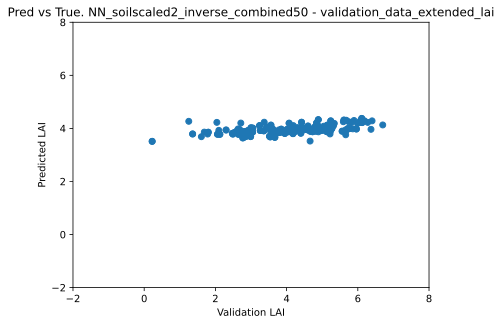

In [45]:
# Plot ypred vs ytest

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Validation LAI')
ax.set_ylabel('Predicted LAI')
ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
ax.set_xlim((-2,8))
ax.set_ylim((-2,8))
#plt.savefig(f'trained_models/pred_vs_true_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

Text(0.5, 1.0, 'Residual. NN_soilscaled2 - validation_data')

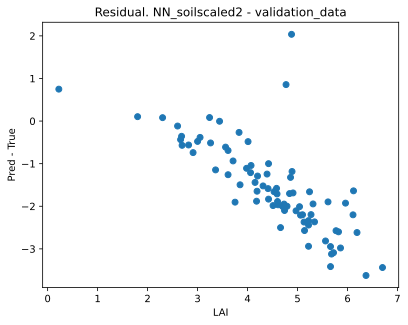

In [32]:
# Plot residuals

fig, ax = plt.subplots()
res = y_pred.squeeze() - y_test
ax.scatter(y_test, res)
ax.set_xlabel('LAI')
ax.set_ylabel('Pred - True')
ax.set_title(f'Residual. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
#plt.savefig(f'trained_models/residual_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

# Test models in low LAI (<4)

In [9]:
# Load config file

config_path = "configs/config_GPR.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

In [10]:

def prepare_data(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''
  data_path = config['Data']['test_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle(data_path)
    X = df[config['Data']['train_cols']]
    y = df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y
    else:
      return X, y

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle(path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    X = concatenated_df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
    y = concatenated_df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y
    else:
      return X, y

  else:
      return None


X_test, y_test = prepare_data(config)

In [11]:
# Keep only low LAI values (<4)

X_low = X_test[y_test < 4]
y_low = y_test[y_test < 4]

In [12]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

In [14]:
# Calculate RMSE
y_pred = model.predict(X_low)
print('Pred variance', y_pred.std())
model.test_scores(y_test=y_low, y_pred=y_pred)


Pred variance 2.4499784722428135
Test RMSE: 2.511113745579221


In [8]:
# Calculate RMSE
y_pred, y_std = model.predict(X_low, return_std=True)
print('GPR std', y_std.mean())
model.test_scores(y_test=y_low, y_pred=y_pred)

TypeError: NeuralNetworkRegressor.predict() got an unexpected keyword argument 'return_std'

# Test in low LAI, extended val set

In [89]:
# Load config file

config_path = "../configs/config_GPR.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

In [90]:
def prepare_data(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''
  data_path = '../' + config['Data']['test_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle(data_path)
    X = df[config['Data']['train_cols']]
    y = df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
      #X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=config['Data']['test_size'], random_state=config['Seed'])
      #print('here')
      #return X_test, y_test
    else:
      return X, y.values

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle(path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    X = concatenated_df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
    y = concatenated_df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
    else:
      return X, y.values

  else:
      return None

X_test, y_test = prepare_data(config)

# Keep only low LAI values (<3)
X_test = X_test[y_test < 3]
y_test = y_test[y_test < 3]

In [91]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X_test, return_std=True)
  print('Mean test std', y_std.mean()) 
  model.test_scores(y_test=y_test, y_pred=y_pred)
else: 
  y_pred = model.predict(X_test=X_test)
  model.test_scores(y_test=y_test, y_pred=y_pred)

Mean test std 3.006659668346499
Test RMSE: 2.024731670278354


(0.0, 8.0)

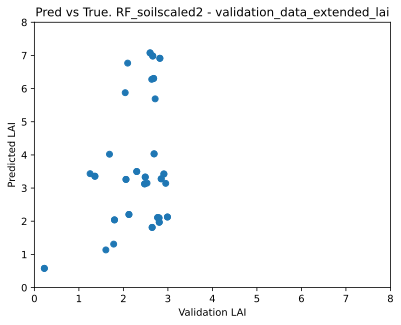

In [79]:
# Plot ypred vs ytest

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Validation LAI')
ax.set_ylabel('Predicted LAI')
ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
ax.set_xlim((0,8))
ax.set_ylim((0,8))
#plt.savefig(f'trained_models/pred_vs_true_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

### For LAI < 3 compare with GCC

In [110]:
# Load config file

config_path = "../configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

data_path = '../../results/validation_data_extended.pkl'
df = pd.read_pickle(data_path)

In [111]:
df = df[df.lai<3]
X = df[config['Data']['train_cols']]
y = df['green_canopy_cover']
if config['Data']['normalize']:
  # Load scaler
  scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
  with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
  # Normalize
  X_test = scaler.transform(X)
  y_test = y.values
else:
  y_test = y.values

In [112]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X_test, return_std=True)
  print('Mean test std', y_std.mean()) 
  #model.test_scores(y_test=y_test, y_pred=y_pred)
else: 
  y_pred = model.predict(X_test=X_test)
  #model.test_scores(y_test=y_test, y_pred=y_pred)

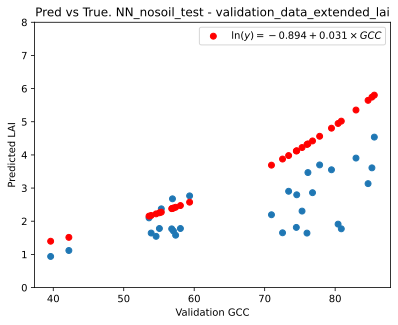

In [108]:
# Plot ypred vs ytest


fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Validation GCC')
ax.set_ylabel('Predicted LAI')
ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
#ax.set_xlim((0,8))
ax.set_ylim((0,8))
#plt.savefig(f'trained_models/pred_vs_true_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

# Plot the empirical relationship found by Vilma
y_values_curve = np.exp(-0.894 + 0.031 * y_test)
ax.scatter(y_test, y_values_curve, color='red', label=r'$\ln(y) = -0.894 + 0.031 \times GCC$')
ax.legend()

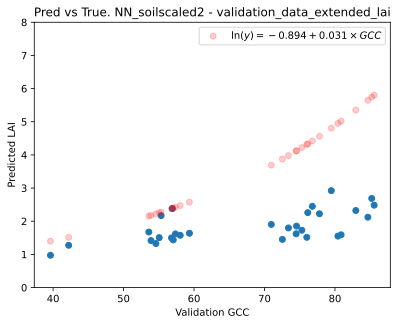

In [118]:
# Plot ypred vs ytest

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Validation GCC')
ax.set_ylabel('Predicted LAI')
ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
#ax.set_xlim((0,8))
ax.set_ylim((0,8))
#plt.savefig(f'trained_models/pred_vs_true_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')


# Plot the empirical relationship found by Vilma
y_values_curve = np.exp(-0.894 + 0.031 * y_test)
ax.scatter(y_test, y_values_curve, color='red', label=r'$\ln(y) = -0.894 + 0.031 \times GCC$', alpha=0.2)
ax.legend()

# Check feature importance of RF

In [11]:
# Load trained model
rf_model = pickle.load(open('../trained_models/RF_soilscaled2_inverse_combined20.pkl', 'rb'))

# Extract feature importances
feature_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
feature_importance = rf_model.feature_importances_

# Create a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importance_df)

  Feature  Importance
7     B8A    0.207073
6     B08    0.168601
5     B07    0.121320
4     B06    0.084324
9     B12    0.082812
0     B02    0.071804
2     B04    0.068514
8     B11    0.066730
3     B05    0.065123
1     B03    0.063699
